# Capstone Project - Signal Generation for Nyse Stock Data 
_Eoin Cunning March 1st 2019_

#### Abstract
_Machine learning methods can be used by several ways to successfully predict prices of financial instruments from the financial time series data of various markets. In this paper we compare and contrast a number of machine learning methods being used to predict next day prices traded NYSE. The performances of these techniques are compared and it is observed that of the models trained the best perfromace came by using grid search optimised Ridge Regression._

## Introduction 
Traditionally stock trading has been performed by humans but with all the unseen un-quantifible decsions that go into human decision making the idea here is to replace that human element with machine learning. Can a machine given historical tick data make predictions on futures movement and therefore recommend cetrain stocks to buy.
Wall steet has been attempting this same problem in various forms with various degrees of sucsess for years now.
We know this problem is solveable as there are multiple papers written on the subject from using SVMs to model the Indian Stock Market[1] to using LSTM to predict stock price movement [2].

#### Problem Statement
The Problem here is to take historical time series tick data. Engieer it into a form where we associate features being previous prices and predict the next day value of the same prices.
This can be a regression or classification problem as we can attempt to predict the exact value of the next day price (regression) or more simply we could try and output a trade signal that would be true or false depending on what we predict the behaviour to be. (classification)

#### Evaluation Metrics
The evaluation metric we have selected for this problem to quantify its performance is the R-square and root-mean-squared-error. 
As we will calculate the exact price of the stock and have an exact value to compare this to we can easily calculate the square root of the average of sqaure errors. 

RMSE Formula:

![equation](https://latex.codecogs.com/gif.latex?RMSE&space;=&space;\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big[\frac{d_i&space;-f_i}{\sigma_i}\Big]^2}})

We will also use a f-score to evaluate our model by considered if we predicted correctly the direction of the price movement. This is only for scoring the model not for defining the problem in order to train model.[3]

F1_score Formula:

![equation](https://latex.codecogs.com/gif.latex?F1&space;=&space;\frac{2&space;\cdot&space;precision\cdot&space;recall}{precision&plus;&space;recall})


##### Justification of metrics

* RMSE - The RMSE allows us to measure not just if our model is correct or incorrect but rather how close it gets to the true value. This is very desirable for model stock market movement the better we can predict what the next price will be the better we can take advantage to then realise profit.
* F1 - Conversly to the RMSE the F1 score here we are not as concerned with how close we get to the true value but rather that our prediction is in the correct direction. This is very important in stock market. As predicting the direction incorrectly would result in lossing money. So this can be seen in this case as a better measure of the relabitly of the model

Phrasing the model in such a way is then extremely advantagous as it then gives us the option of weighing up or balancing between a model that can predict prices and one that can predict the direction of movement. 

#### Outline Of Approach

Our steps to approaching this problem will consist of first familarising ourselves with the data. Performing some basic analysis on the data.
Once we have some more information about the data we can start to consider two things. Firstly what kinds of models suit the data and secondly how can we extract more information from that data to make the models jobs easier. 
For this we can draw inspiration from other papers have found sucsess with the models they chose and how they manipulated the data. We know from [1] that SVMs are a potential candidate and we may use moving averages as an extra feature we could calculate from our data.
Once we have our data,models and benchmark implemented then we will begin to validate and compare them by making a framework that will consolidate the results for us. From this we can then examine where to do further investigation and draw our final conclusions

## Analysis
Firstly we need to look at our data to see what features it has any what information we can extract to make the job of our model easier. And also help us to decide on which model or models we can use.

The full analysis performed on the data is too bulky for this report so has been placed in a seperate notebook:[DataAnalysis](dataAnalysis.ipynb)

Here we will show the basic charictaristics of the data how we filtered down the data we needed and the data engineering performed to extract more information in methof easier to pass into our machine learning algos.

#### Initial load
In the code below we load our data into python for the first time and look at the raw data. We then want to filter the daya to only look at the particular stock we are interested in. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
#load file that defines functions used throughout project 
execfile('functions.py')

In [2]:
#read in the data parse date values 
fulldata = pd.read_csv("prices-split-adjusted.csv", parse_dates=['date'])
#display the data
fulldata.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


/anaconda3/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


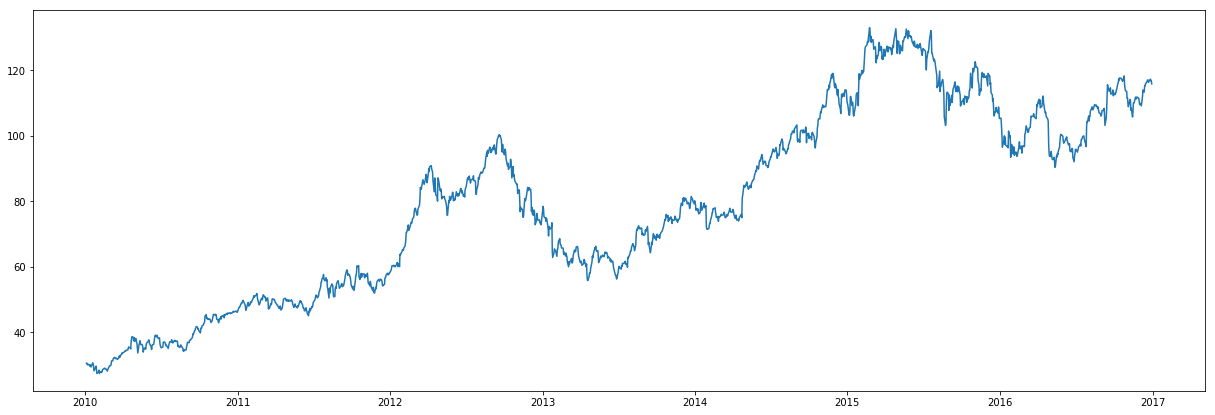

In [3]:
#search for GOOG symbol data using date as the index
data = fulldata[fulldata['symbol'] == "AAPL"]
x = data['date']
y = data['close']
plt.figure(figsize=(21,7))
plt.plot(x, y)
plt.show()

Once getting a better feel for the data and filter down to the stock that we are interested in we can look more closely at his data and so some statistical analysis. Particularly we are looking for any issues or anomalies in the data.

In [4]:
for i in list(data.columns.values)[2:]:
    print("VALUE:",i)
    print("mean         :",np.mean(data[i]))
    print("standard dev :",np.std(data[i]))
    print("max          :",np.max(data[i]))
    print("min          :",np.min(data[i]))

('VALUE:', 'open')
('mean         :', 79.42774447280169)
('standard dev :', 28.33095772907716)
('max          :', 134.46000700000002)
('min          :', 27.481428142800002)
('VALUE:', 'close')
('mean         :', 79.4026827779739)
('standard dev :', 28.322753636765622)
('max          :', 133.0)
('min          :', 27.435714714299998)
('VALUE:', 'low')
('mean         :', 78.64003404268944)
('standard dev :', 28.10054778291947)
('max          :', 131.399994)
('min          :', 27.1785717143)
('VALUE:', 'high')
('mean         :', 80.14044669373504)
('standard dev :', 28.552921387426338)
('max          :', 134.53999299999998)
('min          :', 28.0)
('VALUE:', 'volume')
('mean         :', 94225775.87968218)
('standard dev :', 60188101.00873161)
('max          :', 470249500.0)
('min          :', 11475900.0)


We can see from the graph plotted and the stats calculated for this data that their are no large outliers that need to be ignored. This is to be expected with the nautre of finance data. These are not measurements with a degree of accuracy there are reported numbers that we can find exact values for.

For this reason i see no reason to remove any data to consider annomilies.

#### Algorithms and Techniques

Rather than select one single alorithm we have decide to traing muliple different models and collect results to try and see which model is best suited to this problem. The models we are investigating are:
* Linear Regression -
A linear approach to modelling the relationship between a dependent variable and one (or more) independent variables. This method attempts to define an equation that can capture the relationship between the variables. In its most basic form to train this model we will define a line to try and capture this relationship and the equation of this line would be our model. 

* Random Forest - 
This algorithm starts with randomly selecting a subset of the given features and finding the root node based on the best split approach. We repeat this a number for time until we have a decision tree leading to our classification. We then repeat the entire process to make multiple trees (or our random forest).
when we are then using this to classify based on inputs we run it through each of the decision trees and then combine the outputs of all the trees by a majority vote usually through ensemble learning.

* Stochastic Gradient Decent Regression - 
In this method we apply the gradient decent technique to Logistic Regression. We apply a loss function to our classifcation to see what the gradient of our error is and move towards minimizing that error. We repeat this method itteratively until we reach a number of defined iterations or stop improving our model.

* Support Vector Machine Regression -
The goal of SVM regression is to create the hyperplane that best represents the data by measuring and minimizing the error of the true results from this plane. Also refered to as maximizing the margin. This is done using the kernal trick where we can raise the data into a higher dimensions so that it is in a from that we can represent in a plane.

* Lasso Regression -
Lasso (least absolute shrinkage and selection operator) is a linear model that estimate sparse coefficents. It has a tendency to select solutions with fewer features that it is trained on. This can reduce the number of features upon which the final model it produces is dependent.

* Ridge Regression -
This algorithm is similar to linear (least squares) regression attempting to minimize the sum of square error but adds an additional notion of penalising estimates. When adjusting it chooses the feature's estimates to penalize in such a way that less influential features undergo more penalization. And therefore have less influence as we continue to train the model.

These have been selected after reading various papers of such models being used in practice previouslly and also following general guides to selecting models based on our dataset.
We've also tried to keep some variety to compare results.
We will then look at the basic results after attempting each of these and see if any of these models are worth refining.


### Pre Processing/Feature Engineering

##### Defining additional features from the data
The main aim of this sectoin is to capture in our features not just the values from a single previous day. If we want to look for patterns in the data to make predictions we need to look at more that just the previous days values.
However there a re a number of ways this can be attempted.
One way, the method that was first considered was to time series split the value and have x number of previous close values associated with the next day previous close.
However this is very arbitrary and doesnt really fit with many of our models. Many of the models that we intend to use assign weightings to the various features in the rawest form this doesnt seem to make sense.

Instead what we can do take well known financial principles and calculate them from x days of histoical values previous to the target value for prediction and use these as features to pass into our models. This accomplishes our main goal of associating a number of features with one desired variable to predict.

The features or indicators that we calulated and added to the data were:

* Moving Average Convergence Divergence (MACD) - 
This indicator is calculated by look at two exponential weighted averages from a longer and then shorter window. Another exponential average is then done on the difference between these. This feature will provide an indication of the momentumn of the stock price in how its behaving coming up to the point in time before we will be traing to predict the next value. 

* Relative Strength Index (SMI) - 
This indicator is again a momentum indicator and measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock. 

* Simple Moving Average (SMA) - 
Similar to above but just a simplier version. Takes sum of all price values in last x days and then divides by x.

* Bollinger Bands(BB) - 
This indicator is a measure of voltility by measuring the high/low in the given window

The important part of what these functions do is that they are performed on a rolling time window. We evaluate features from the timeseries data. So that we can use more information than just the previous days price to attempt to predict the next days value.

_The functions that we use to create these additional features can be found in functions.py_

#### Benchmark
If we impose the constraints that prices must move in ticks and must move up or down. Then theoricatilly the very worst we model we ccould come up with would randomly guess up or down based on previous price movement. This lends itself well to a Random Forest Regressor so that is what we will use as the benchmark to compare our trained and refined model.
This will be the first model that we train once we have implemented our framework to train and compare all the various algos.


## Implementation
### Methodology Summary 

Most of the method and implemtation of this project is captured in the framework create to train,validate and compare the various models.
The initial approach for this project imported data for a single symbol of data and then trained only a few models on that data.
Once this was done we started repeating this process for other symbols to try test the model further.

Once we understand the concepts behind are models and have selected those that we feel suit the problem we are facing the actual steps of training them testing them on the data is very similar. We therefore wrote functions to take a classifier that we gave it and train it on the data already loaded. And then test itself against at validation data set.
These results could then be displayed but more importantly could be added to a table to compare against the other models.

This allowed us to tain many more models and see the benefits and drawbacks of different models and also allowed us to easily add additional information after the fact and re run for multiple models. This is what allowed us to also gather information on time taken to train each model so we could consider that when select which had the best performance.

Now with this abilty to be able to train mutliple models. We then decided we should train many initial models then look at those that at least could out perform our benchmark and then select one to refine further and see if we could improve its performance.

### Method
We again read in the data and filter for our instrument of choice. Then add the additional features calculated from the windows of values. We also attempt to remove any nulls by filling in values. 
Finally we normalise the values so the size of the price values dont matter.

We then define from the data what the value we are attempting to predict will be. This will be what we compare against to score our trained algos. And we split the data into test and validation data.

In [5]:
fullData = pd.read_csv("prices-split-adjusted.csv", parse_dates=['date'])
features,target,validation_X,validation_y,f1_validation_y = getDataForTicker("AAPL")

In [6]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score,f1_score
import matplotlib.dates as mdates

timeseriesCv = TimeSeriesSplit(n_splits=10)
### create our table for our restuls
results = pd.DataFrame(columns=['rmse','r2','f1','timeToFit']) 

#### Benchmark - Random Forest
As referenced earilier our choice of benchmark was the random forest. Here we get a visual representation of what the model we are trying to create needs to be better than and we also add the scores for this function to a table of results fo comparrison. 

This algorithm starts with randomly selecting a subset of the given features and finding the root node based on the best split approach. We repeat this a number for time until we have a decision tree leading to our classification. We then repeat the entire process to make multiple trees (or our random forest). when we are then using this to classify based on inputs we run it through each of the decision trees and then combine the outputs of all the trees by a majority vote usually through ensemble learning.

/anaconda3/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


('RMSE: ', 0.015002397792004645)
('R2 score: ', 0.9021946371573243)
('F1 score: ', 0.345679012345679)


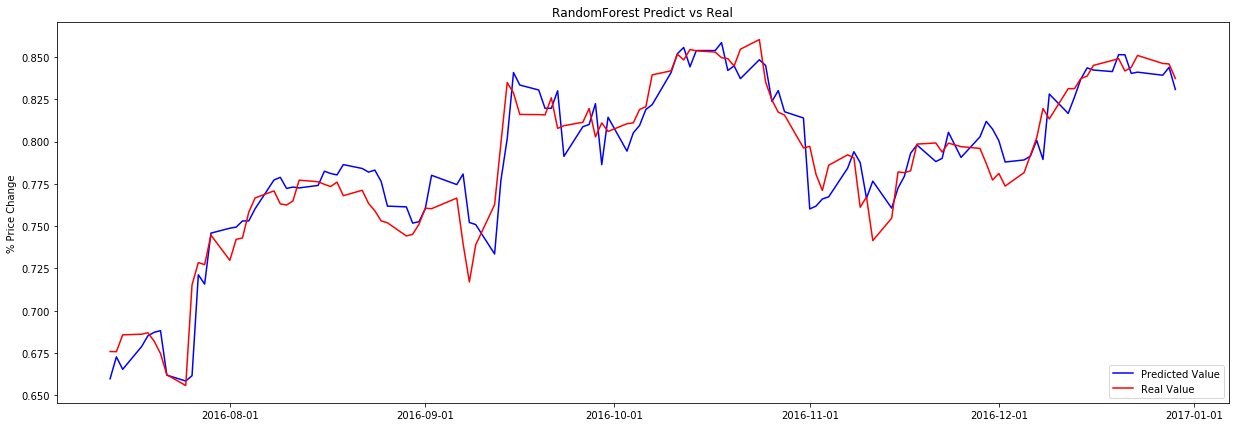

In [7]:
from sklearn.ensemble import RandomForestRegressor

randomForestClf = RandomForestRegressor(random_state=21)
trainAndValidateClf(randomForestClf, 'RandomForest')

#### Model One - Linear Regression
A linear approach to modelling the relationship between a dependent variable and one (or more) independent variables. This method attempts to define an equation that can capture the relationship between the variables. In its most basic form to train this model we will define a line to try and capture this relationship and the equation of this line would be our model.

('RMSE: ', 0.012504481069660572)
('R2 score: ', 0.9320526283395199)
('F1 score: ', 0.4788732394366197)


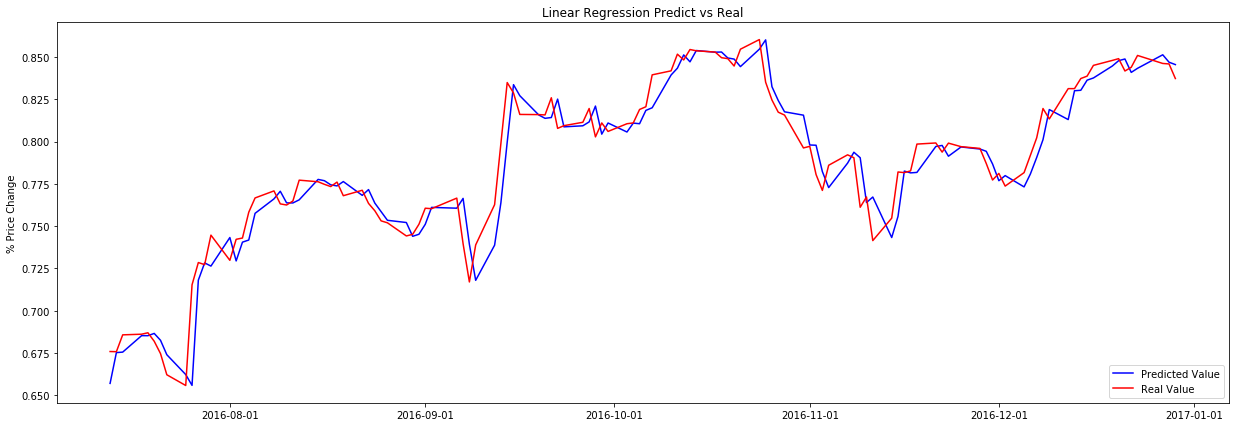

In [8]:
from sklearn import linear_model

linearRegressionClf = linear_model.LinearRegression()
trainAndValidateClf(linearRegressionClf, 'Linear Regression')

#### Model Two - SGDRegressor
In this method we apply the gradient decent technique to Logistic Regression. We apply a loss function to our classifcation to see what the gradient of our error is and move towards minimizing that error. We repeat this method itteratively until we reach a number of defined iterations or stop improving our model.


('RMSE: ', 0.02250652509990736)
('R2 score: ', 0.7798806561551116)
('F1 score: ', 0.7027027027027027)


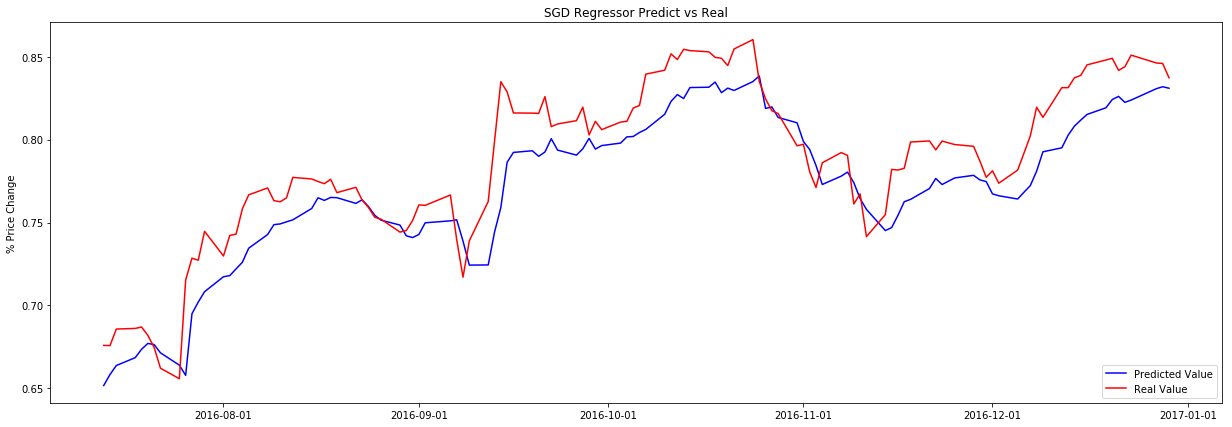

In [9]:
from sklearn.linear_model import SGDRegressor

sgdrClf = SGDRegressor(tol=1e-3,max_iter=10000,random_state=21)
trainAndValidateClf(sgdrClf,'SGD Regressor')

#### Model Three - Support Vector Machines
The goal of SVM regression is to create the hyperplane that best represents the data by measuring and minimizing the error of the true results from this plane. Also refered to as maximizing the margin. This is done using the kernal trick where we can raise the data into a higher dimensions so that it is in a from that we can represent in a plane.

Here we are actually running three different flavours of Support Vectory Machines. This is part of the benefit of have the reusable code to pass these calssifiers into.

('RMSE: ', 0.012603805032239079)
('R2 score: ', 0.9309689199849022)
('F1 score: ', 0.4615384615384615)


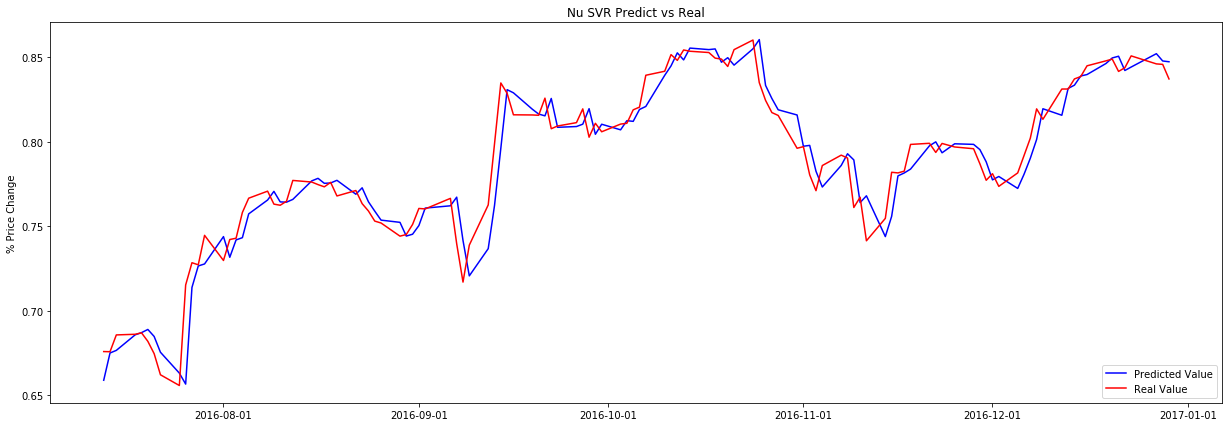

('RMSE: ', 0.038664606665473555)
('R2 score: ', 0.3503663566829328)
('F1 score: ', 0.18181818181818182)


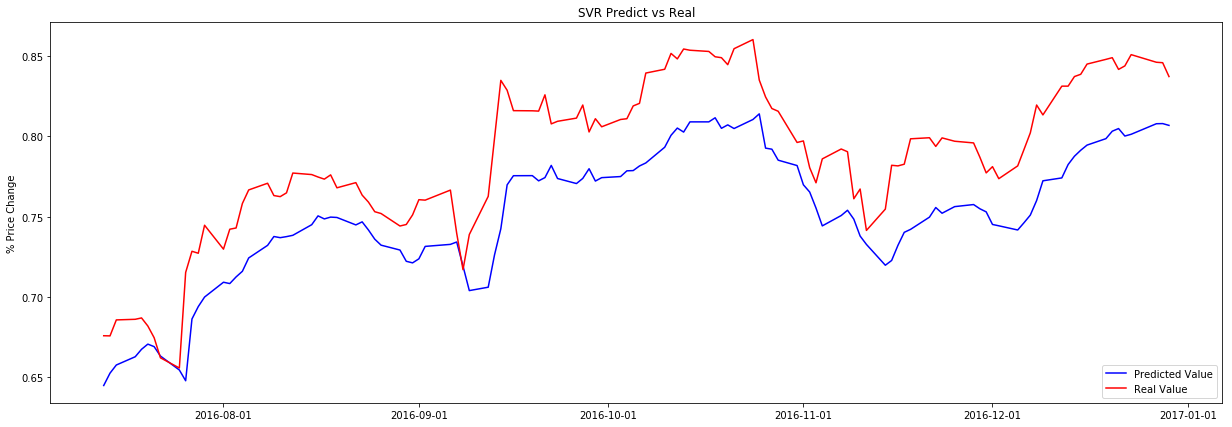

('RMSE: ', 0.012611225691361834)
('R2 score: ', 0.9308876101088476)
('F1 score: ', 0.48648648648648646)


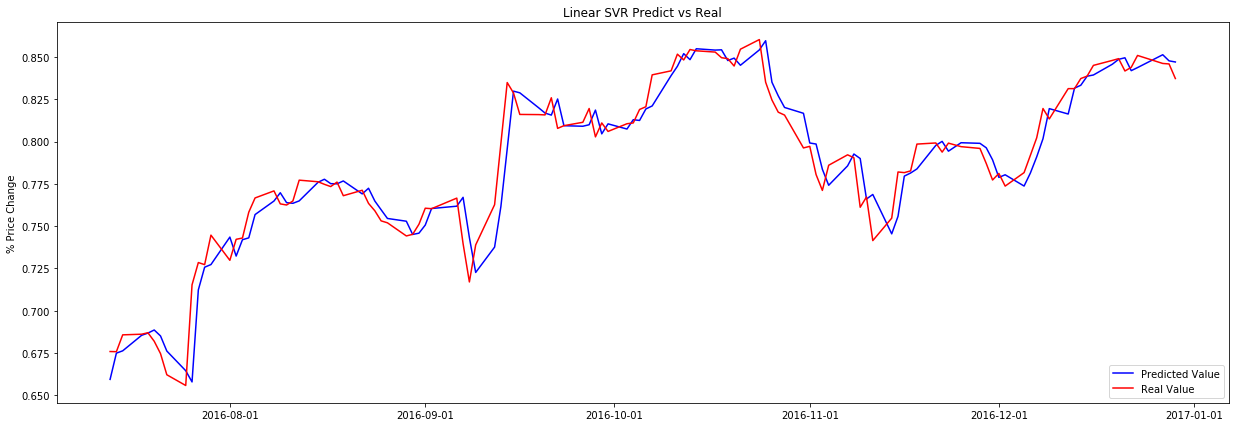

In [10]:
from sklearn.svm import SVR
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR

# Compare three kinds of SVR
nu_svr_clf = NuSVR(kernel='linear')
trainAndValidateClf(nu_svr_clf,'Nu SVR')

svr_clf = SVR(kernel='linear')
trainAndValidateClf(svr_clf,'SVR')

linear_svr_clf = LinearSVR(random_state=21)
trainAndValidateClf(linear_svr_clf,'Linear SVR')

#### Model Five - LassoCV
Lasso (least absolute shrinkage and selection operator) is a linear model that estimate sparse coefficents. It has a tendency to select solutions with fewer features that it is trained on. This can reduce the number of features upon which the final model it produces is dependent.

In this version of Lasso the best parameters are selected by Cross Validation

('RMSE: ', 0.012693010746451155)
('R2 score: ', 0.9299883020139401)
('F1 score: ', 0.5294117647058825)


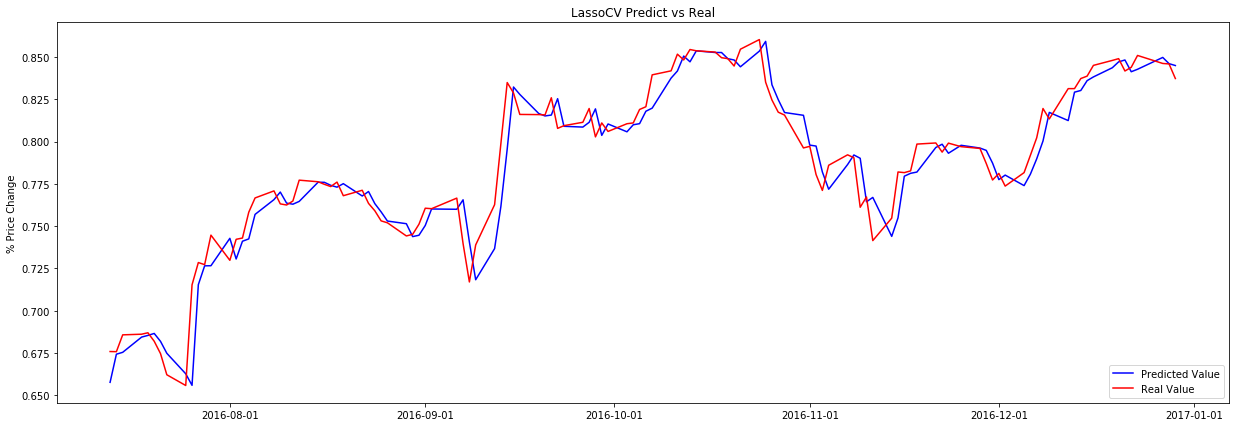

In [11]:
from sklearn.linear_model import LassoCV

lassoClf = LassoCV(n_alphas=1000, max_iter=3000, random_state=21)
trainAndValidateClf(lassoClf,'LassoCV')

#### Model Five - Ridge Regression
This algorithm is similar to linear (least squares) regression attempting to minimize the sum of square error but adds an additional notion of penalising estimates. When adjusting it chooses the feature's estimates to penalize in such a way that less influential features undergo more penalization. And therefore have less influence as we continue to train the model.

('RMSE: ', 0.013466916197844667)
('R2 score: ', 0.9211906709027595)
('F1 score: ', 0.5405405405405406)


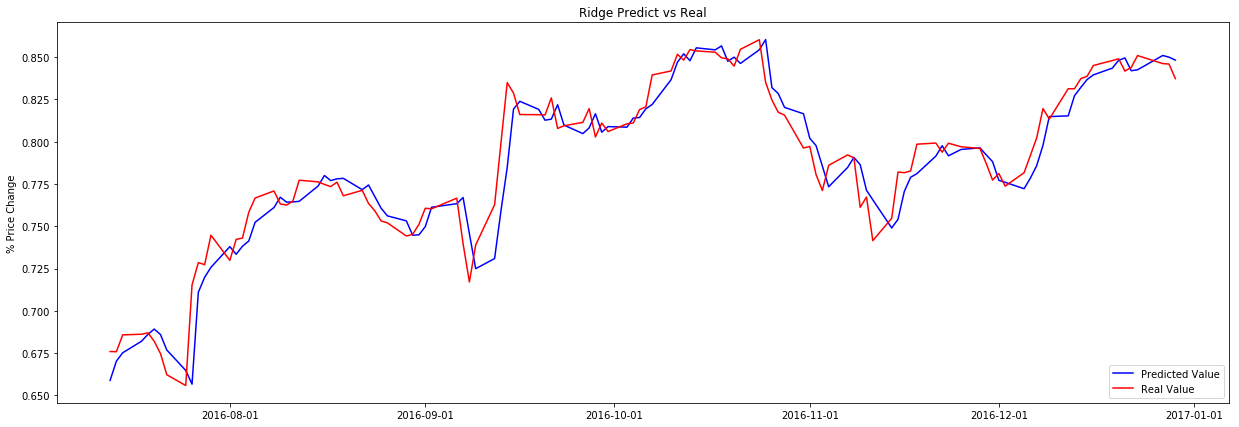

In [12]:
from sklearn.linear_model import Ridge

ridgeClf = Ridge()
trainAndValidateClf(ridgeClf,'Ridge')

### Refinement

In this section we attempt to refine a model. We have stored all our results so far in the table below:

In [13]:
results

,rmse,r2,f1,timeToFit
RandomForest,0.0150024,0.902195,0.345679,0.160822
Linear Regression,0.0125045,0.932053,0.478873,0.00113702
SGD Regressor,0.0225065,0.779881,0.702703,0.00226712
Nu SVR,0.0126038,0.930969,0.461538,2.95341
SVR,0.0386646,0.350366,0.181818,0.00110102
Linear SVR,0.0126112,0.930888,0.486486,0.115751
LassoCV,0.012693,0.929988,0.529412,0.828295
Ridge,0.0134669,0.921191,0.540541,0.00211692


From this table we can evaluate the models relative performance by comparing their metrics and also seeing how long it took comperatively to fit the data. 

Based on this table we can select what model we should attempt to refine further. 

#### Boosting

Based on the results so far one interesting result is for the model using SGD Regressor. It has the best performance of all models of the f1 score and is also one of the faster models to fit to the test data. 

In a attempt to try and get a better r2 score for this model that already has a good f1 score. The f1 score that it is correctly predicting the direction of the movement of the close price. This can be considered reliable in some sense where as r2 would be more related to accuarcy. 

Taking the trained SGD Classifier we will pass it through a boosting model to try and improve the result

('RMSE: ', 0.016745589386265063)
('R2 score: ', 0.8781453263840855)
('F1 score: ', 0.6666666666666665)


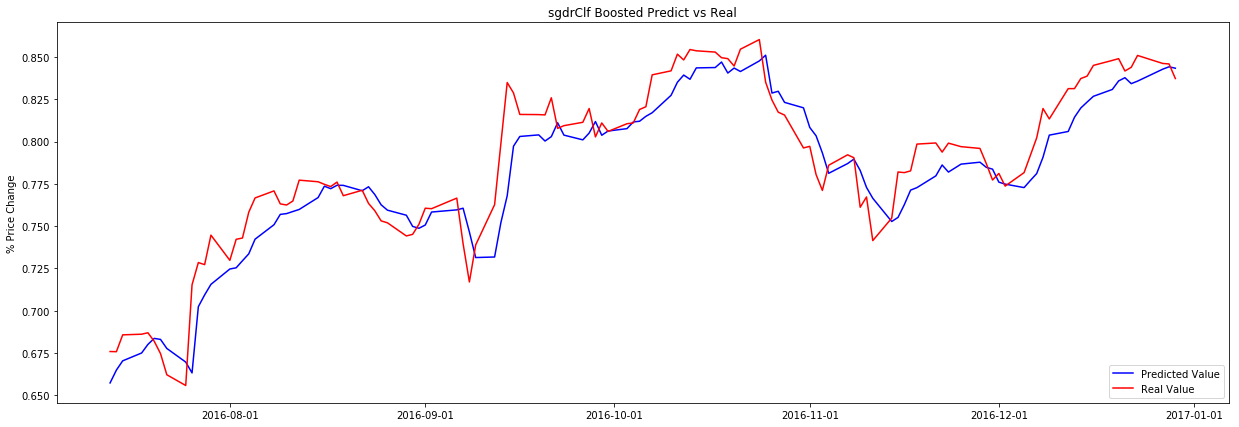

In [14]:
from sklearn.ensemble import AdaBoostRegressor

adaBoostClf = AdaBoostRegressor(base_estimator= sgdrClf,n_estimators=10,random_state=21,loss='exponential')
trainAndValidateClf(adaBoostClf,'sgdrClf Boosted')

We can see here that we manged to improve the r2 score but have sacrificed the f1 score slightly. 
Although this model seems to be more accurate it seems to lose some relaibilty in preidicting the direction of the price movement.


#### Tuning using grid search
Since boosting didnt have the desired effect when we go back to the table the model that stands out as having the best performance is the Ridge Model. Scoring: r2 Score:0.921191, f1 Score:0.540541 . And also having a relatively lower training time. This is then the model that we have selected to try and tune further to find the optimal set of parameters through grid search.

We use grid search to find the optimal set of paramters for this model and then we validate the model trained with this parameters agains the same data as before.

0.9859044317147113
{'alpha': 0.0, 'solver': 'svd', 'fit_intercept': False}
('RMSE: ', 0.012458142581600403)
('R2 score: ', 0.9325552872710892)
('F1 score: ', 0.49275362318840576)


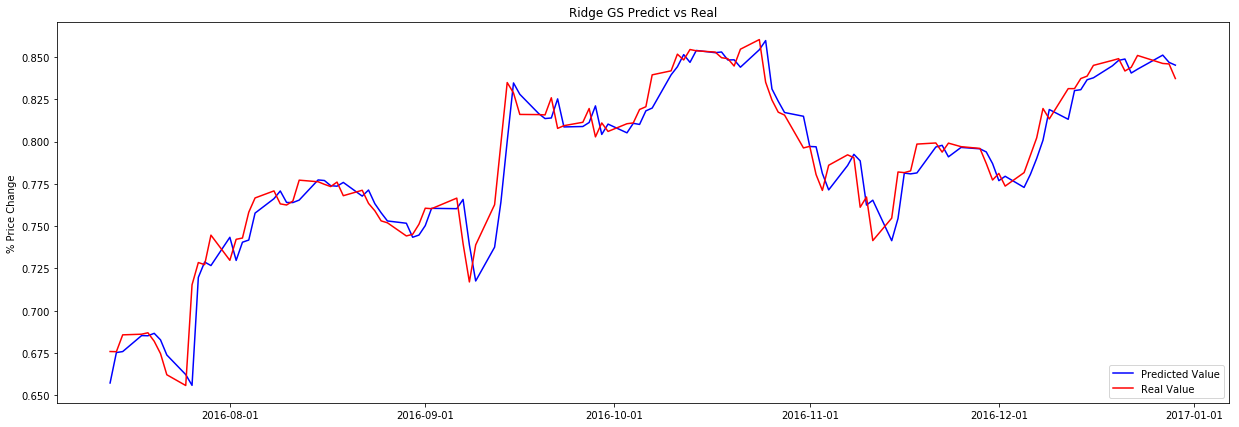

In [15]:
#Grid Search
from sklearn.model_selection import GridSearchCV

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
fit_interceptOptions = ([True, False])
solverOptions = (['svd', 'cholesky', 'sparse_cg', 'sag'])
#create and fit a ridge regression model, testing each alpha
model = Ridge(normalize=True) 
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas, fit_intercept=fit_interceptOptions, solver=solverOptions))
grid.fit(features, target.values.ravel())

print(grid.best_score_)

print(grid.best_params_)
validateResult(grid,'Ridge GS')

We can now display our final table with the set of results from all te models we've trained.

In [16]:
results

,rmse,r2,f1,timeToFit
RandomForest,0.0150024,0.902195,0.345679,0.160822
Linear Regression,0.0125045,0.932053,0.478873,0.00113702
SGD Regressor,0.0225065,0.779881,0.702703,0.00226712
Nu SVR,0.0126038,0.930969,0.461538,2.95341
SVR,0.0386646,0.350366,0.181818,0.00110102
Linear SVR,0.0126112,0.930888,0.486486,0.115751
LassoCV,0.012693,0.929988,0.529412,0.828295
Ridge,0.0134669,0.921191,0.540541,0.00211692
sgdrClf Boosted,0.0167456,0.878145,0.666667,0.08481
Ridge GS,0.0124581,0.932555,0.492754,NaN


We can see that using grid search has improved the r2 score of the Ridge model and is the best scoring model.

## Results
We have selected our Grid search optimised Ridge Model as the best model to use for prediciting next day stock data.

In order to test the Robustness of our solution lets load data for another symbol and see how the model performs on that.

('RMSE: ', 0.041544437852367756)
('R2 score: ', -1.0280863936486475)
('F1 score: ', 0.19047619047619044)


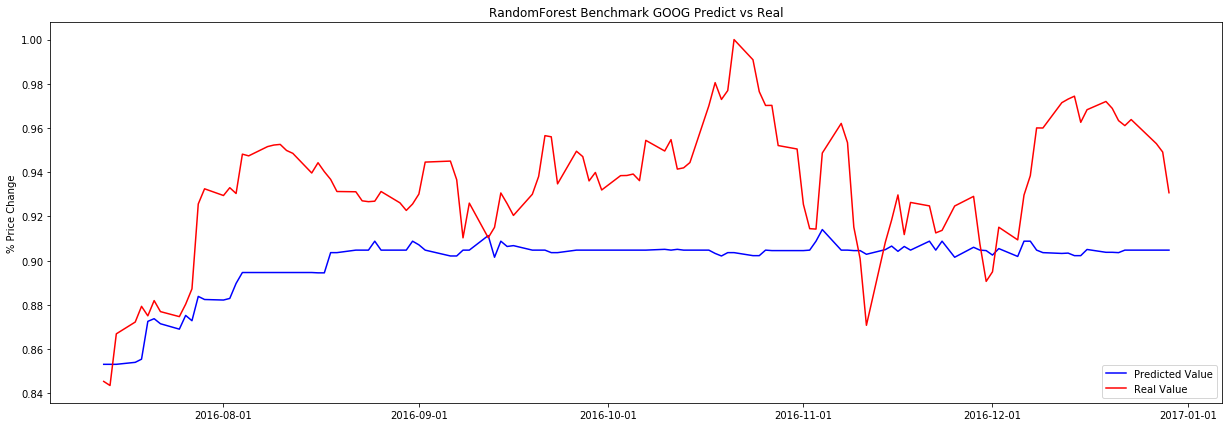

('RMSE: ', 0.02140337176108787)
('R2 score: ', 0.46169914743750173)
('F1 score: ', 0.4861111111111111)


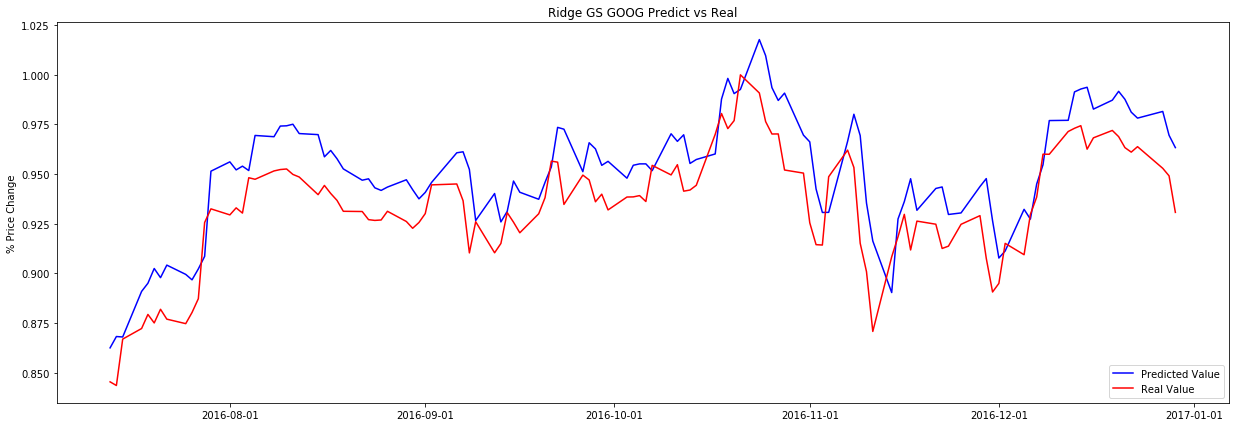

In [17]:
features,target,validation_X,validation_y,f1_validation_y = getDataForTicker("GOOG")
randomForestClf = RandomForestRegressor(random_state=21)
trainAndValidateClf(randomForestClf, 'RandomForest Benchmark GOOG')
validateResult(grid,'Ridge GS GOOG')

We would obviouslly expect the performance to be a little worse here as the behaviour of this stock could be slightly different. But in these results our refined and trained model significantly outperforms our benchmark model even if it is trained on data for that symbol.

We would them deem that we have sucsefully trained a model to capture generic NYSE stock data and can succsessfully predict to a degree better than our selected benchmark the next closing price using previous days data that has undergone data engineering.

## Conclusion
In this project we have trained a number of models and evaluated each of them. Then when able to compare the various models we determined that the best algorythm in this case was the Grid Search Optimised Ridge Regression Model. 

The next natural steps for this project would be to expand it do more data. To train on test on more symbols from the NYSE stock data. Potentially look at grouping together stocks of similar industries or independtly try and group together those with similar behaviour.

Also need to look more into the use cases of the model. Is this abilty useful? Is the abilty to predict prices only useful in more granular time windows and in that case how will that change the models we consider if training time becomes more of a factor.

We could also look to improve about the idea of reliability versus accuarcy and other ways to train our models to optimise this. 

Finally the most important thing about these models is getting a recommenation out of them whether to buy or sell and once that suggestions has been provided doing a profit analysis of the models across time would be most effective way of grading the various models and selecting which is best for our purposes.

### Reflection
The most interesting aspect of this work was the potential of the results. It seems to have produced quite a reasonable results from some basic methods. 

The biggest challange of this project i think was select and honing in on a project theres such a vast array of options and possible implemenations that trying to focus down the topic of machine learning into a project is quite difficult. 

I learned about multiple different machine learning models and how they work and some benefits and drawbacks of each. Also learned some financial domain knowledge.
I improved my python skills and how to use git and different python modules.

## References
    [1] Support Vector Machines for Prediction of Futures Prices in Indian Stock Market - Shom Prasad Das, Sudarsan Padhy 
    [2] Predicting Stock Prices Using LSTM - Murtaza Roondiwala, Harshal Patel, Shraddha Varma
    [3] scikit-learn.org - Documentation 
